In [783]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results, run_glm

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib as mpl
from mne.stats import fdr_correction


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [784]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False





In [785]:
# FV Study Parameters
ignore = [".DS_Store", ".git", "sub-14", "sub-18", ".gitignore"]
# "sub-14", "sub-15", "sub-16", "sub-17", "sub-18", "sub-19",
columns_for_group_analysis = ['Neutral', 'Concern']
columns_for_glm_contrast = ['Neutral', 'Concern']
path = '../../FV_Prelim_Data/'
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
columns_for_fdr = ['Neutral', 'Concern']
sc_present = False

In [786]:
# FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [787]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [788]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [789]:
# Live Drive
# ignore = [".DS_Store", ".git", "sub-01", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../LiveDrive'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']

In [790]:
# VR Driving
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Drive_VR/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [791]:
# Live Drive w/ Pause
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Driving_with_pause/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [792]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time, tmin=tmin, tmax=tmax)
        
        print("sc_present group analysis", sc_present)
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [793]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [794]:
importlib.reload(analysis_tools)
importlib.reload(glm_analysis)
print(sc_present)
group_data, all_epochs, all_evokeds, glm_results = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

# print(glm_results)


False
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-13/nirs/2023-03-09_001.snirf
Reading 0 ... 9146  =      0.000 ...   899.052 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-15/nirs/2023-03-22_005.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8796  =      0.000 ...   864.647 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-12/nirs/2023-02-10_003.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 8750  =      0.000 ...   860.125 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-08/nirs/2023-02-17_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9088  =      0.000 ...   893.350 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-01/nirs/2023-02-17_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 8713  =      0.000 ...   856.488 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-06/nirs/2023-02-10_004.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9282  =      0.000 ...   912.421 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-07/nirs/2023-02-17_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9460  =      0.000 ...   929.918 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-09/nirs/2023-03-01_004.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 13102  =      0.000 ...  1287.927 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-17/nirs/2023-03-22_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 11307  =      0.000 ...  1111.478 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-10/nirs/2023-03-08_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 11040  =      0.000 ...  1085.232 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-19/nirs/2023-03-23_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9278  =      0.000 ...   912.027 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-11/nirs/2023-02-10_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 10100  =      0.000 ...   992.830 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-16/nirs/2023-03-22_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9757  =      0.000 ...   959.113 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-05/nirs/2023-02-10_003.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9566  =      0.000 ...   940.338 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-02/nirs/2023-02-23_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8780  =      0.000 ...   863.074 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-03/nirs/2023-02-10_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9439  =      0.000 ...   927.854 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-04/nirs/2023-02-10_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8961  =      0.000 ...   880.866 secs...


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


sc_present group analysis False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PRESENT False
SHORT CHANNEL PR

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)


In [795]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, trigger_id)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

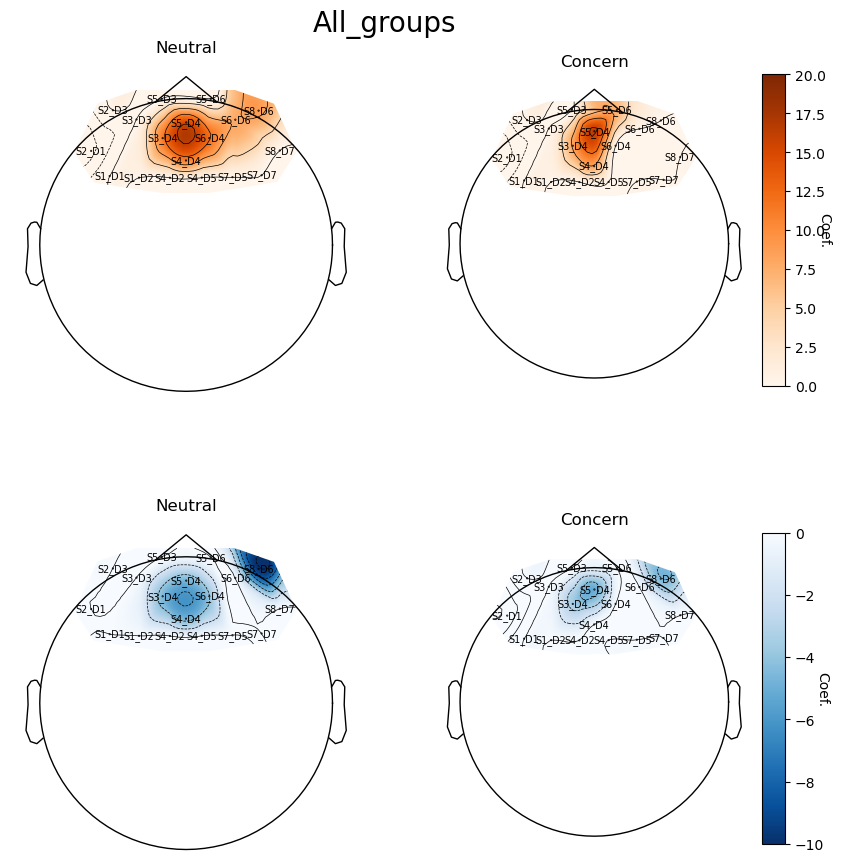

In [796]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

In [804]:
# Group Visualization with FDR Correction
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    channels_df_fdr = analysis_tools.false_discovery_rate_correction(channels_df, ignored_vals, columns_for_fdr)

    raw_haemo = all_data[0]['raw_haemo']

    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    channels_df_fdr = channels_df_fdr.drop_duplicates()
    print(channels_df_fdr)
    channels_df_fdr.to_csv('FV_results_FDR.csv')
    
    # channels_df_fdr.to_csv('channels_df_fdr.csv')
    # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

variable Condition    df           mse   p_value            se         t  \
4768       Neutral  21.0  3.949961e-12  0.000007  6.879842e-07  5.931251   
5146       Neutral  21.0  4.394964e-13  0.000007  2.294878e-07 -5.931251   
34662      Concern  21.0  2.888732e-12  0.000010  6.028842e-07  5.751643   
35040      Concern  21.0  3.850156e-13  0.000010  2.200997e-07 -5.751643   

variable     theta Source Detector Chroma  Significant    ch_name  ID  \
4768      0.000004      5        6    hbo         True  S5_D6 hbo  12   
5146     -0.000001      5        6    hbr         True  S5_D6 hbr  12   
34662     0.000003      5        4    hbo         True  S5_D4 hbo   2   
35040    -0.000001      5        4    hbr         True  S5_D4 hbr   2   

variable  fdr_status  
4768            True  
5146            True  
34662           True  
35040           True  


In [798]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


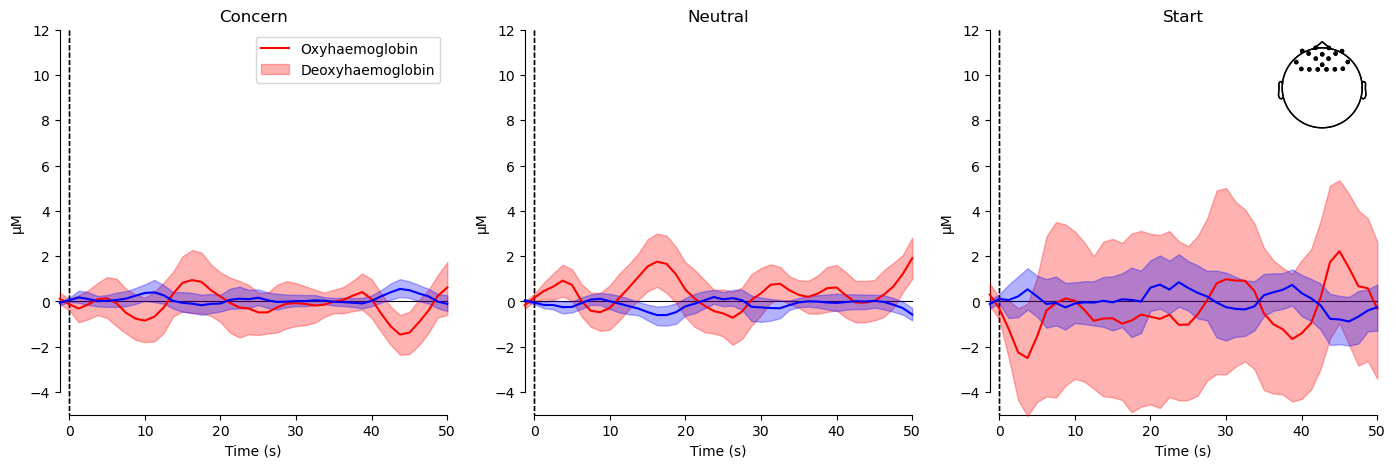

In [799]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

In [800]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [803]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    print(sig_cha)
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e7
complete_results.to_csv('FV_results.csv')

                            Coef. Std.Err.         z         P>|z|    [0.025  \
ch_name   Condition                                                            
S2_D1 hbo Concern   -9.040275e-07      0.0 -2.750068  5.958299e-03 -0.000002   
          Neutral   -8.999443e-07      0.0 -2.737646  6.188058e-03 -0.000002   
S3_D4 hbo Concern    8.463504e-07      0.0  2.574613  1.003524e-02       0.0   
          Neutral    1.123546e-06      0.0  3.417848  6.311838e-04       0.0   
S4_D4 hbo Concern    7.749630e-07      0.0  2.357451  1.840088e-02       0.0   
          Neutral    1.034470e-06      0.0  3.146876  1.650251e-03       0.0   
S5_D4 hbo Concern    1.647227e-06      0.0  5.010894  5.417776e-07  0.000001   
          Neutral    1.566249e-06      0.0  4.764557  1.892691e-06  0.000001   
S5_D6 hbo Concern    7.118386e-07      0.0  2.165425  3.035512e-02       0.0   
S6_D4 hbo Neutral    1.227729e-06      0.0  3.734774  1.878836e-04  0.000001   
S6_D6 hbo Neutral    7.802244e-07      0